In [23]:
from google.colab import drive
drive.mount("/content/gdrive")
root_dir = 'gdrive/My Drive/Colab Notebooks/Model type'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import torch
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#torch.backends.cuda.cufft_plan_cache.max_size = 2048
#torch.cuda.empty_cache()
from torch import nn, optim
import datetime
from torchvision import datasets, transforms, models
from PIL import Image
from collections import OrderedDict

In [0]:
class TempletLayer(nn.Module):

  def __init__(self, n_input, n_output, kernel, stride):
    super(TempletLayer, self).__init__()
    self.conv = nn.Conv2d(n_input, n_output, kernel_size=kernel, stride=stride, bias=False)
    self.bn =  nn.BatchNorm2d(n_output, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    self.relu = nn.ReLU(inplace=True)
    #self.pool = nn.AvgPool2d(kernel_size=kernel, stride=stride,   ceil_mode=False) #dilation=1,
    
   
  def forward(self, x):
     x = self.conv(x)
     x = self.bn(x)
     x = self.relu(x)
     #x = self.pool(x)
     return x


In [0]:
class Net(nn.Module):
  
  def __init__(self):
    super(Net, self).__init__()
    self.features = nn.Sequential(
                    OrderedDict([('layer1', TempletLayer( n_input=3, n_output=1024, kernel=(5,5), stride=(2,2)) ),
                                 ('maxpool1' , nn.MaxPool2d(kernel_size=(3,3), stride=(1,1), dilation=1,  ceil_mode=False) ),
                                 ('layer2', TempletLayer( n_input=1024, n_output=512, kernel=(3,3), stride=(1,1)) ),
                                 ('maxpool2' , nn.MaxPool2d(kernel_size=(2,2), stride=(1,1), dilation=1,  ceil_mode=False) ),
                                 ('layer3', TempletLayer( n_input=512, n_output=256, kernel=(3,3), stride=(1,1)) ),
                                 ('maxpool3' , nn.MaxPool2d(kernel_size=(2,2), stride=(1,1), dilation=1,  ceil_mode=False) ),
                                 ('adtavgpool' , nn.AvgPool2d(kernel_size=(4,4), stride=(4,4), ceil_mode=False) ),
                                ]))
    self.adtpool = nn.AdaptiveMaxPool2d(output_size=(1, 1)) 
    self.classifier = nn.Sequential(
                        OrderedDict([ ('dropout1', nn.Dropout(p=0.3, inplace=False)), 
                                      ('fc1', nn.Linear(256, 5)),
                                      ('output', nn.LogSoftmax(dim=1))
                                      ]))                           
    self.criterion = nn.NLLLoss()
    self.transform = transforms.Compose([transforms.Lambda(self.centre_crop), 
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
    self.train_transform = transforms.Compose([transforms.ToTensor(),
                                                  transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
    self.train_loss_hist = [] 
    self.val_loss_hist = []
    self.val_acc_hist = []

  def forward(self, x):
    x = self.features(x)
    x = self.adtpool(x)
    x = x.flatten(1) 
    x = self.classifier(x)
    return x

  @staticmethod
  def centre_crop(image):
    a , b = image.size
    main_edge = a if a < b else b
    ratio = main_edge/224
    new_a, new_b = int(a/ratio), int(b/ratio)
    crop_a, crop_b = int((new_a - 224)/2) , int((new_b-224)/2)
    image = image.resize((new_a, new_b))
    image = image.crop((crop_a,crop_b,crop_a+224,crop_b+224))
    return image
  
  
  def fit(self, trainloader, testloader, device, epochs=5, save_path='model.torch', optimizer = None):

    if optimizer is None:
      optimizer = optim.Adam(self.parameters(), lr=0.0005)
    
    self.to(device)

    for e in range(epochs):
      self.train()
      train_loss = 0.0

      estart = datetime.datetime.now()
      print('starting epoch ', e , ' at  ' , estart )
      
      for images, labels  in trainloader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        predicts = self(images)
        
        loss = self.criterion(predicts, labels)
        loss.backward()
        optimizer.step()       
        train_loss += float(loss)

        del images, labels, loss, predicts
                        
      else:
        train_loss = train_loss/ len(trainloader)
        print('train_loss = ', train_loss )
        print('End of epoch ', e , ' at  ' , datetime.datetime.now() , 'duration = ', datetime.datetime.now() - estart )
        self.evaluate(testloader=testloader, device=device, save_path=save_path, train_loss=train_loss, save = True ) 


  def evaluate(self, testloader, device, save_path, train_loss=0, save = False, initial_val_acc = None ):

    if initial_val_acc is None:
      try:
        initial_val_acc = max(self.val_acc_hist)
      except (IndexError, ValueError) as e:
          initial_val_acc = 0
    estart = datetime.datetime.now()
    print('Starting validation at ' , estart )
    self.to(device)
    self.eval()
    val_acc = 0.0
    val_loss = 0.0
    with torch.no_grad():
      for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        predicts = self(images)

        loss = self.criterion(predicts, labels)
        val_loss += float(loss)

        predicts = torch.exp(predicts)
        top_p, top_class = predicts.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        val_acc+= float(torch.mean(equals.type(torch.FloatTensor)).item())

        del images, labels, loss, predicts, top_p, top_class, equals
          
    self.train()
    val_acc =  val_acc/ len(testloader)
    val_loss =  val_loss/ len(testloader)
    print('End of validation at ' , datetime.datetime.now() , 'duration = ', datetime.datetime.now() - estart )
    print('val_acc= ', val_acc,'val_loss=',val_loss)

    if save:
      self.train_loss_hist.append(train_loss)
      self.val_loss_hist.append(val_loss) 
      self.val_acc_hist.append(val_acc)  
      
      if val_acc >= initial_val_acc:
        print('saving model in ', save_path)
        torch.save(self, save_path)
    
    return val_acc, val_loss
          



            


In [27]:
model_path = '/model_clasifier_v_3_0.torch'
model = torch.load( root_dir + model_path, map_location=torch.device('cpu') )
model

Net(
  (features): Sequential(
    (layer1): TempletLayer(
      (conv): Conv2d(3, 1024, kernel_size=(5, 5), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (maxpool1): MaxPool2d(kernel_size=(3, 3), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (layer2): TempletLayer(
      (conv): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (layer3): TempletLayer(
      (conv): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (maxpool3): MaxPool2d(kernel_size=(2, 2), stride

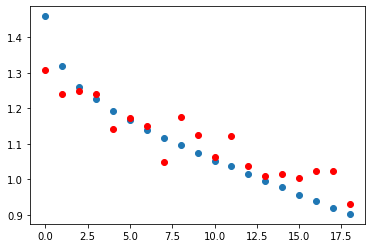

In [28]:
from matplotlib import pyplot as plt
plt.scatter(range(len(model.train_loss_hist)),model.train_loss_hist )
plt.scatter(range(len(model.val_loss_hist)), model.val_loss_hist, c='r' )

In [0]:
! cp gdrive/My\ Drive/Colab\ Notebooks/Model\ type/train_data100.zip .
! cp gdrive/My\ Drive/Colab\ Notebooks/Model\ type/test_data100.zip .

In [0]:
!unzip test_data100.zip
!unzip train_data100.zip

In [0]:
import os
import numpy as np

In [0]:
files = os.listdir('train_data/1plus/')

In [17]:
len(files)

15163

In [0]:
a = np.random.choice(files, size=5000, replace=False ).tolist()

In [0]:
for f in a:
    os.remove('train_data/1plus/' + f)

In [20]:
len(os.listdir('train_data/1plus/'))

10163

In [0]:
!zip -r train_data100_new.zip train_data/

In [0]:
! cp train_data100_new.zip gdrive/My\ Drive/Colab\ Notebooks/Model\ type